In [1]:
from lbmpy.session import *
from lbmpy.phasefield.n_phase_boyer import *
from lbmpy.phasefield.kerneleqs import *
from lbmpy.phasefield.contact_angle_circle_fitting import *
from scipy.ndimage.filters import gaussian_filter
from pystencils.simp import sympy_cse_on_assignment_list
one = sp.sympify(1)

import pyximport
pyximport.install(language_level=3)
from lbmpy.phasefield.simplex_projection import simplex_projection_2d  # NOQA

# Simulation arbitrary surface tension case

In [2]:
n = 4
dx, dt = 1, 1
mobility = 2e-3
domain_size = (150, 150)
ε = one * 4
penalty_factor = 0
stabilization_factor = 10

κ = (one,  one/2, one/3, one/4)
sigma_factor = one / 15
σ = sp.ImmutableDenseMatrix(n, n, lambda i,j: sigma_factor* (κ[i] + κ[j]) if i != j else 0 )
#σ

In [3]:
dh = create_data_handling(domain_size, periodicity=True, default_target='gpu')
c = dh.add_array('c', values_per_cell=n)
c_tmp = dh.add_array_like('c_tmp', 'c')

μ = dh.add_array('mu', values_per_cell=n)

cvec = c.center_vector
μvec = μ.center_vector

In [4]:
α, _ = diffusion_coefficients(σ)

f = lambda c: c**2 * ( 1 - c ) **2
a, b = compute_ab(f)

capital_f = capital_f0(cvec, σ) + correction_g(cvec, σ) + stabilization_factor * stabilization_term(cvec, α)

f_bulk = free_energy_bulk(capital_f, b, ε) + penalty_factor * (one - sum(cvec))
f_if = free_energy_interfacial(cvec, σ, a, ε)
f = f_bulk + f_if

In [5]:
#f_bulk

In [6]:
μ_assignments = mu_kernel(f, cvec, c, μ)
μ_assignments = [Assignment(a.lhs, a.rhs.doit()) for a in μ_assignments]
μ_assignments = sympy_cse_on_assignment_list(μ_assignments)

In [7]:
discretize = fd.Discretization2ndOrder(dx=dx, dt=dt)

In [8]:
rhs = α * μvec
discretized_rhs = [discretize(fd.expand_diff_full( Diff(Diff(mobility * rhs_i)) + fd.transient(cvec[i], idx=i), functions=μvec))
                   for i, rhs_i in enumerate(rhs)]
c_assignments = [Assignment(lhs, rhs) 
                 for lhs, rhs in zip(c_tmp.center_vector, discretized_rhs)]

In [9]:
#c_assignments

In [10]:
μ_sync = dh.synchronization_function(μ.name)
c_sync = dh.synchronization_function(c.name)
optimization = {'cpu_openmp': 4, 'cpu_vectorize_info': None}
μ_kernel = create_kernel(μ_assignments, target=dh.default_target, **optimization).compile()
c_kernel = create_kernel(c_assignments, target=dh.default_target, **optimization).compile()

def set_c(slice_obj, values):
    for block in dh.iterate(slice_obj):
        arr = block[c.name]
        arr[..., : ] = values

def smooth():
    for block in dh.iterate(ghost_layers=True):
        c_arr = block[c.name]
        for i in range(n):
            gaussian_filter(c_arr[..., i], sigma=2, output=c_arr[..., i])
        
def time_loop(steps):
    dh.all_to_gpu()
    for t in range(steps):
        c_sync()
        dh.run_kernel(μ_kernel)
        μ_sync()
        dh.run_kernel(c_kernel)
        dh.swap(c.name, c_tmp.name)
        #simplex_projection_2d(dh.cpu_arrays[c.name])
    dh.all_to_cpu()

In [11]:
set_c(make_slice[:, :], [0, 0, 0, 0])
set_c(make_slice[:, 0.5:], [1, 0, 0, 0])
set_c(make_slice[:, :0.5], [0, 1, 0, 0])
set_c(make_slice[0.3:0.7, 0.3:0.7], [0, 0, 1, 0])
smooth()

In [12]:
#dh.load_all('n_phases_state_size200_stab10.npz')

/local/bauer/miniconda3/envs/pystencils_dev/lib/python3.7/site-packages/matplotlib/contour.py:1243: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"


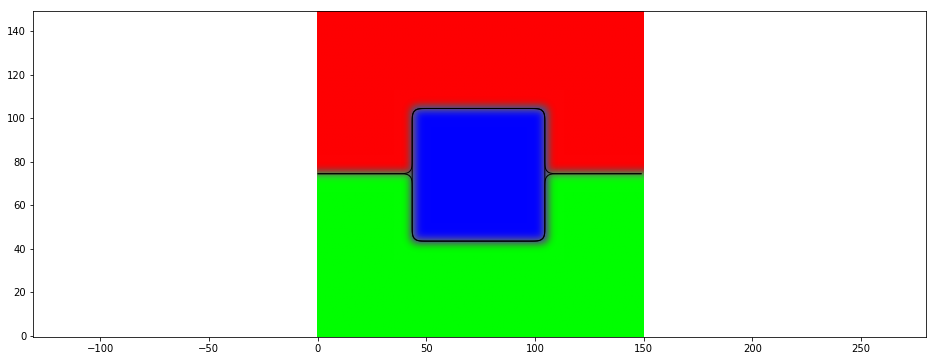

In [13]:
plt.phase_plot(dh.gather_array(c.name))

In [14]:
neumann_angles_from_surface_tensions(lambda i, j: float(σ[i, j]))

In [15]:
import time
for i in range(10):
    start = time.perf_counter()
    time_loop(1_000)
    end = time.perf_counter()

    try:
        print(i, end - start, liquid_lens_neumann_angles(dh.gather_array(c.name)))
    except Exception:
        print(i, end - start, "none found")

0 0.4948967100003756 [83.97834853343086, 100.48843351167487, 175.53321795489427]
1 0.46325071699993714 [83.73089000952169, 100.65861489552344, 175.6104950949548]
2 0.4162677360000089 [83.49917147819785, 100.82171580037817, 175.679112721424]
3 0.4208440130000781 [83.31522725116703, 100.94465624438456, 175.74011650444845]
4 0.4054762699997809 [83.14244042613915, 101.06096493509406, 175.79659463876686]
5 0.4099374320003335 [82.98452286961921, 101.16728073593467, 175.84819639444606]
6 0.4051740560003054 [82.84784900062101, 101.25699289301976, 175.89515810635933]
7 0.38569620899988877 [82.74572683273676, 101.31684772333017, 175.93742544393302]
8 0.3827051820003362 [82.67014193290147, 101.35096921023188, 175.9788888568664]
9 0.4393134040001314 [75.9000636413822, 108.96518552940361, 175.13475082921425]


/local/bauer/miniconda3/envs/pystencils_dev/lib/python3.7/site-packages/matplotlib/contour.py:1243: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"


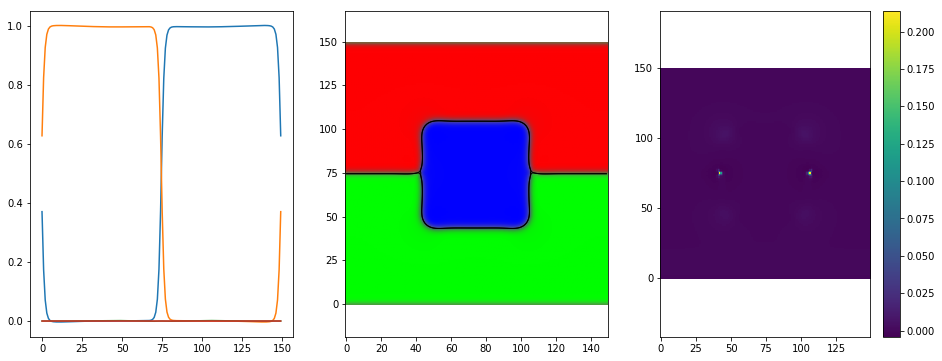

In [16]:
plt.subplot(1,3,1)
t = dh.gather_array(c.name, make_slice[25, :]).squeeze()
plt.plot(t);

plt.subplot(1,3,2)
plt.phase_plot(dh.gather_array(c.name), linewidth=1)

plt.subplot(1,3,3)
plt.scalar_field(dh.gather_array(μ.name)[:, :, 2])
plt.colorbar();

In [17]:
assert not np.isnan(dh.max(c.name))

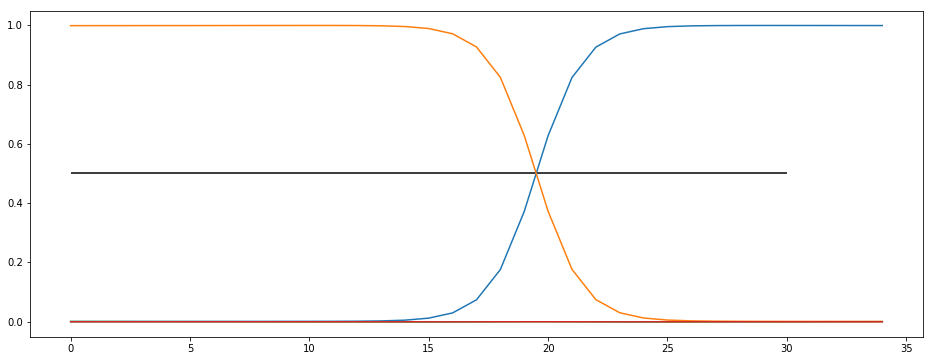

In [18]:
t = dh.gather_array(c.name, make_slice[25, 55:90]).squeeze()
plt.hlines(0.5, 0, 30)
plt.plot(t);